# News scraper

In [9]:
from google.colab import drive
drive.mount('/content/drive')

import sys

if "/content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES" not in sys.path:
  sys.path.append("/content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES")


BASE_PATH = "/content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/"

model_path = "/content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/models/huffpost-model"

collection_path = "/content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/collection/collection-huffpost-model.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!pip install feedparser > 0
!pip install bs4 > 0
!pip install transformers
!pip install sumy > 0
#!pip install fakeyou > 0
!pip install TTS > 0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
plotnine 0.12.4 requires numpy>=1.23.0, but you have numpy 1.22.0 which is incompatible.
pywavelets 1.5.0 requires numpy<2.0,>=1.22.4, but you have numpy 1.22.0 which is incompatible.
tensorflow 2.15.0.post1 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.22.0 which is incompatible.


In [11]:
#FAKEYOU_CDN_BASELINK = "https://storage.googleapis.com/vocodes-public"
#
#FAKEYOU_USERNAME = "pippoJ"
#FAKEYOU_PASSWORD = "password"
#FAKEYOU_MODEL_GERRY_SCOTTI = "TM:5ggf3m5w2mhq"
#FAKEYOU_MODEL_TOKEN = FAKEYOU_MODEL_GERRY_SCOTTI

In [12]:
!pip install TensorFlow -U

  Using cached numpy-1.26.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.0
    Uninstalling numpy-1.22.0:
      Successfully uninstalled numpy-1.22.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
tts 0.22.0 requires numpy==1.22.0; python_version <= "3.10", but you have numpy 1.26.3 which is incompatible.


In [13]:
! pip install numpy==1.24.4

  Using cached numpy-1.24.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.3
    Uninstalling numpy-1.26.3:
      Successfully uninstalled numpy-1.26.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
tts 0.22.0 requires numpy==1.22.0; python_version <= "3.10", but you have numpy 1.24.4 which is incompatible.


In [14]:
import transformers

from transformers import TextClassificationPipeline, pipeline

In [15]:
import feedparser
import pandas as pd
import time
from bs4 import BeautifulSoup
import os
import numpy as np
import torch


from ast import literal_eval

#from fakeyou import FakeYou
from TTS.api import TTS

TTS_MODEL = "tts_models/multilingual/multi-dataset/xtts_v2"
TTS_OUTPUT_DIR = BASE_PATH + "generated_audio/"

VOICE_SAMPLE_FILE_PATH = BASE_PATH + "voices/obama.mp3"

from transformers import TextClassificationPipeline, pipeline

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer

import re

import nltk
nltk.download('punkt')

# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"


def summarize_article(article_text, num_sentences=3):

    # Use extractive summarization with LSA
    summarizer = LsaSummarizer()
    parser = PlaintextParser.from_string(article_text, Tokenizer("english"))
    summary_sentences = summarizer(parser.document, num_sentences)

    # Convert the summary sentences to a single string
    summary = ' '.join(str(sentence) for sentence in summary_sentences)

    return summary


def parse_date(date_struct_time):
    date_str = time.strftime('%Y-%m-%d %H:%M:%S', date_struct_time)
    return date_str

def normalize_embedding(list):
    vector = np.array(list)
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector.tolist()

class NewsScraper:
    def __init__(self, embedder_pipe : TextClassificationPipeline, summarization_pipe, csv_file_path=None, fakeyou_obj = None):
        #self.rss_url = rss_url

        self.embedder = embedder_pipe
        self.summarizer = summarization_pipe
        self.tts = TTS(TTS_MODEL).to(device)
        self.fakeyou = fakeyou_obj
        self.entries = []
        if csv_file_path is not None and os.path.isfile(csv_file_path):
          def f(x):
              x = str(x)
              if "," not in x:
                x = x.replace(" ", ", ")
              try:
                  return literal_eval(str(x))
              except Exception as e:
                  print(e)
                  print("given x:" , x)
                  return []

          conv = {'Embedding': lambda x: f(x)}
          self.df = pd.read_csv(csv_file_path, converters=conv, index_col=0)
          print(f"Loaded dataframe of {len(self.df)} rows")
        else:
          print("Creating new empty dataframe")
          self.df = pd.DataFrame(columns=['Link', 'Title', 'Summary', 'Article', 'Date', 'Embedding'])  #, index=["Link"]


    def is_already_present(self, link) -> bool:
        return link in self.df["Link"].values
        #return False

    def fetch_news(self, rss_url, do_print=True):
        feed = feedparser.parse(rss_url)
        entries = feed.entries

        for entry in entries:
          try:
              print(entry)

              title = entry.title
              article_str = BeautifulSoup(entry.summary, "lxml").get_text(separator=' ')
              if "<br /><br /><hr /><br /><br />" in entry.summary:
                    rss_summary = (entry.summary).split('<br /><br /><hr /><br /><br />')[0]
                    article_str = BeautifulSoup((entry.summary).split('<br /><br /><hr /><br /><br />')[1], "lxml").get_text(separator=' ')


              else:
                if do_print:
                  print(f"Skipping empty body news of title: {title}")
                  print("-" * 50)
                continue

              date = parse_date(entry.published_parsed)
              link = entry.link

              # do not process twice the same news
              if self.is_already_present(link):
                if do_print:
                  print(f"Skipping already indexed news of title: {title}")
                  print("-" * 50)
                continue

              if title in self.df["Title"].values:
                title += " " + date.split(" ")[0]

              article_text_extract = summarize_article(article_str, num_sentences = 12)
              summary = self.summarizer(article_text_extract, min_length=50, max_length=100)[0]["summary_text"]

              wav_link = None


              if self.tts != None:
                tmp_wav_file_name = title.replace(" ", "-")
                #.replace(".", "").replace("'", "").replace("(", "").replace(")", "").replace("?", "").replace(",", "").replace(":","") + ".wav"
                pattern = re.compile('[^a-zA-Z0-9\-]')
                tmp_wav_file_name = pattern.sub('', tmp_wav_file_name)

                wav_file_name = tmp_wav_file_name + '.wav'
                tmp_cnt=1

                while True:

                  if wav_file_name in os.listdir(TTS_OUTPUT_DIR):
                    wav_file_name = tmp_wav_file_name + f'({tmp_cnt})' + '.wav'
                  else:
                    break
                  tmp_cnt+=1

                self.tts.tts_to_file(text=summary, speaker_wav = VOICE_SAMPLE_FILE_PATH, language="en", file_path=TTS_OUTPUT_DIR + wav_file_name)

              elif self.fakeyou != None:
                wav_obj = self.fakeyou.say(summary, FAKEYOU_MODEL_TOKEN)
                if wav_obj.status == "complete_success":
                  wav_link = FAKEYOU_CDN_BASELINK + wav_obj.json["maybe_public_bucket_wav_audio_path"]

              model_output = self.embedder(article_text_extract)
              embedding = []
              for row in model_output[0]:
                embedding.append(row["score"])

              normalized_embedding = normalize_embedding(embedding)

              if do_print:
                print(f"Keys: {entry.keys()}")
                print(f"Title: {title}")
                print(f"Original summary field: {entry.summary}")
                print(f"RSS summary: {rss_summary}")
                print(f"article_str: {article_str}")
                print(f"article_text_extract: {article_text_extract}")
                print(f"Generated summary: {summary}")
                print(f"Generated embedding: {embedding}")
                print(f"Normalized embedding: {normalized_embedding}")
                #if "content" in entry.keys(): print(f"Content: {entry.content}")
                print(f"Date: {date}")
                print(f"Link: {link}")
                print("-" * 50)

              new_record = pd.DataFrame({'Link':link,'Title': title, 'Summary': summary, 'Article':article_text_extract, 'Date': date, 'Wav-link': wav_link, 'wav_file_name': wav_file_name,  'Embedding': [normalized_embedding]})
              self.df = pd.concat([self.df, new_record], ignore_index=True)
          except Exception as e:
              print(e)
              print("exception for entry: ", entry)
              continue
            #return

    def save_to_csv(self, output_file_path):
        #print(self.df)
        try:
          os.makedirs("/".join(collection_path.split("/")[:-1]))
        except:
          pass
        self.df.to_csv(output_file_path)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
from transformers import TextClassificationPipeline, DistilBertTokenizerFast, TFDistilBertForSequenceClassification

tokenizer_inference = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
trainer_model_inference = TFDistilBertForSequenceClassification.from_pretrained(model_path)

embedder_pipe = TextClassificationPipeline(model=trainer_model_inference, tokenizer=tokenizer_inference, return_all_scores=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Some layers from the model checkpoint at /content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/models/huffpost-model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_239']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/models/huffpost-model and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream 

In [17]:
#hf_name = "pszemraj/led-base-book-summary"
#hf_name = "pszemraj/pegasus-x-large-book-summary"
hf_name="facebook/bart-large-cnn"
summarization_pipe = pipeline("summarization", model=hf_name, device= 0 if torch.cuda.is_available() else -1,) #pipeline("summarization")

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [18]:
news_scraper = NewsScraper(embedder_pipe, summarization_pipe, collection_path)


 > You must confirm the following:
 | > "I have purchased a commercial license from Coqui: licensing@coqui.ai"
 | > "Otherwise, I agree to the terms of the non-commercial CPML: https://coqui.ai/cpml" - [y/n]
 | | > y
 > Downloading model to /root/.local/share/tts/tts_models--multilingual--multi-dataset--xtts_v2


100%|█████████▉| 1.86G/1.87G [00:32<00:00, 63.1MiB/s]
100%|██████████| 1.87G/1.87G [00:32<00:00, 56.7MiB/s]
100%|██████████| 4.37k/4.37k [00:00<00:00, 10.7kiB/s]

100%|██████████| 361k/361k [00:00<00:00, 765kiB/s]
100%|██████████| 32.0/32.0 [00:00<00:00, 39.0iB/s]
 70%|██████▉   | 5.43M/7.75M [00:00<00:00, 54.3MiB/s]

 > Model's license - CPML
 > Check https://coqui.ai/cpml.txt for more info.
 > Using model: xtts


100%|██████████| 7.75M/7.75M [00:15<00:00, 54.3MiB/s]

Loaded dataframe of 129 rows


In [19]:
#news_scraper.df = news_scraper.df[news_scraper.df['wav_file_name'].notna()]
news_scraper.df

,Link,Title,Summary,Article,Date,Embedding,Wav-link,wav_file_name
0,https://www.huffpost.com/entry/federal-judge-t...,Judge In Trump’s Election Interference Case Re...,U.S. District Judge Tanya Chutkan appears to h...,"U.S. District Judge Tanya Chutkan, who is over...",2024-01-09 00:11:52,"[0.011138527885328387, 0.02186892848835519, 0....",NaN,Judge-In-Trumps-Election-Interference-Case-Rep...
1,https://www.huffpost.com/entry/ap-us-baby-cut-...,Chicago Woman Who Pleaded Guilty To Murder Wil...,Desiree Figueroa’s plea was made Monday at the...,CHICAGO (AP) — A 29-year-old Chicago woman has...,2024-01-09 00:09:10,"[0.005128548086176076, 0.004703588834842205, 0...",NaN,Chicago-Woman-Who-Pleaded-Guilty-To-Murder-Wil...
2,https://www.huffpost.com/entry/mark-hamill-nat...,Mark Hamill's Golden Globes Tweet Will Warm Th...,"Mark Hamill played Luke Skywalker in six ""Star...","For many celebrities, Sunday’s Golden Globes ...",2024-01-09 00:03:16,"[0.02437375273648491, 0.0015506252984578658, 0...",NaN,Mark-Hamills-Golden-Globes-Tweet-Will-Warm-The...
3,https://www.huffpost.com/entry/michelle-obama-...,Michelle Obama Says 2024 Election Worries Keep...,The former first lady spoke on Jay Shetty’s po...,Michelle Obama revealed in an interview Monda...,2024-01-08 22:41:49,"[0.009637841407010564, 0.01813716131956467, 0....",NaN,Michelle-Obama-Says-2024-Election-Worries-Keep...
4,https://www.huffpost.com/entry/joe-biden-charl...,Biden Interrupted By Protesters Calling For Ce...,President Joe Biden was interrupted by protest...,President Joe Biden was interrupted by prote...,2024-01-08 22:41:44,"[0.013763099622201317, 0.01437901715327914, 0....",NaN,Biden-Interrupted-By-Protesters-Calling-For-Ce...
...,...,...,...,...,...,...,...,...
124,https://www.bbc.co.uk/news/uk-67932595?at_medi...,Hundreds of Post Office scandal victims to hav...,"Emergency laws announced to ""swiftly exonerate...",27 minutes ago About sharing By Sean Seddon & ...,2024-01-10 17:56:17,"[0.013419449119504127, 0.8993142252251043, 0.0...",NaN,Hundreds-of-Post-Office-scandal-victims-to-hav...
125,https://www.bbc.co.uk/news/world-latin-america...,Streets empty as Ecuador reels from violence,Masked gunmen stormed a public TV studio durin...,1 hour ago About sharing Watch: Armed men inte...,2024-01-10 17:13:54,"[0.011262254040623448, 0.00671375867524755, 0....",NaN,Streets-empty-as-Ecuador-reels-from-violence.wav
126,https://www.bbc.co.uk/news/world-europe-679354...,Austrian heiress Marlene Engelhorn announces p...,Traudl Engelhorn-Vechiatto's wealth was estima...,"Marlene Engelhorn, who is 31 and lives in Vien...",2024-01-10 15:47:49,"[0.174392322903461, 0.8785816579167656, 0.0769...",NaN,Austrian-heiress-Marlene-Engelhorn-announces-p...
127,https://www.huffpost.com/entry/trader-joes-uni...,"Trader Joe’s Illegally Fired Union Supporter, ...","Stephen Andrade, who worked nearly 18 years fo...",Prosecutors at the National Labor Relations Bo...,2023-12-20 17:14:28,"[0.014092791199047359, 0.7387293487568887, 0.0...",NaN,Trader-Joes-Illegally-Fired-Union-Supporter-La...


In [20]:
# rss_url is the URL of the RSS feed
#rss_url = "https://morss.it/:clip/feeds.bbci.co.uk/news/rss.xml"#"https://feeds.bbci.co.uk/news/rss.xml"#'https://www.ilsole24ore.com/rss/mondo--europa.xml'

print("Fetching new data...")
rss_url_list =[
    "https://morss.it/:clip/https://www.huffpost.com/section/us-news/feed",
    "https://morss.it/:clip/feeds.bbci.co.uk/news/rss.xml",
    "https://morss.it/:clip/https://www.huffpost.com/section/business/feed",
    "https://morss.it/:clip/https://www.huffpost.com/section/celebrity/feed",
    "https://morss.it/:clip/https://www.huffpost.com/section/media/feed",
    "https://morss.it/:clip/https://www.huffpost.com/section/tv/feed",
    "https://morss.it/:clip/https://www.huffpost.com/section/money/feed",
    "https://morss.it/:clip/https://www.huffpost.com/section/worklife/feed",
    "https://morss.it/:clip/https://www.theguardian.com/sport/blog/rss",
    "https://morss.it/:clip/https://21sportsnews.com/feed/",
    "https://morss.it/:clip/https://news.22bet.com/news/feed/",
    "https://morss.it/:clip/https://www.247sportsgist.com/feed/",
    "https://morss.it/:clip/https://ashsportstalk.org/feed/",
    "https://morss.it/:clip/rss.cnn.com/rss/money_markets.rss",
    "https://morss.it/:clip/rss.cnn.com/rss/money_pf_taxes.rss",
    "https://morss.it/:clip/https://www.theverge.com/google/rss/index.xml",
    "https://morss.it/:clip/https://www.wired.com/feed/tag/ai/latest/rss",
    "https://morss.it/:clip/https://www.wired.com/feed/category/science/latest/rss",
    "https://morss.it/:clip/https://nypost.com/entertainment/feed/",
    "https://morss.it/:clip/https://nypost.com/media/feed/",
    "https://morss.it/:clip/https://www.latimes.com/environment/rss2.0.xml",
    "https://morss.it/:clip/https://www.etonline.com/news/rss",
    "https://morss.it/:clip/https://therevealer.org/feed/",
    "https://morss.it/:clip/https://thepoliticalinsider.com/feed/",
    "https://morss.it/:clip/https://www.teachertoolkit.co.uk/category/podcasts/feed/",
    "https://morss.it/:clip/https://humornama.com/feed/",
    "https://morss.it/:clip/https://www.sciencedaily.com/rss/top/science.xml",
    "https://morss.it/:clip/https://www.newscientist.com/subject/space/feed/"
]

for url in rss_url_list:
  news_scraper.fetch_news(url)
  news_scraper.save_to_csv(collection_path)


Output hidden; open in https://colab.research.google.com to view.

In [21]:
news_scraper.save_to_csv(collection_path)

In [22]:
len(news_scraper.df)

181

In [23]:
from ast import literal_eval

def f(x):
    x = str(x)
    if "," not in x:
      x = x.replace(" ", ", ")
    try:
        return literal_eval(str(x))
    except Exception as e:
        print(e)
        print("given x:" , x)
        return []

conv = {'Embedding': lambda x: f(x)}
dfFoo = pd.read_csv(collection_path, converters=conv, index_col=0)

## Show stored news embeddings

In [24]:
from ast import literal_eval
import pandas as pd

def f(x):
    x = str(x)
    if "," not in x:
      x = x.replace(" ", ", ")
    try:
        return literal_eval(str(x))
    except Exception as e:
        print(e)
        print("given x:" , x)
        return []

conv = {'Embedding': lambda x: f(x)}
df= pd.read_csv(collection_path, converters=conv, index_col=0)

labels = df['Title']
embeddings = df['Embedding']

In [25]:
df

,Link,Title,Summary,Article,Date,Embedding,Wav-link,wav_file_name
0,https://www.huffpost.com/entry/federal-judge-t...,Judge In Trump’s Election Interference Case Re...,U.S. District Judge Tanya Chutkan appears to h...,"U.S. District Judge Tanya Chutkan, who is over...",2024-01-09 00:11:52,"[0.011138527885328387, 0.02186892848835519, 0....",NaN,Judge-In-Trumps-Election-Interference-Case-Rep...
1,https://www.huffpost.com/entry/ap-us-baby-cut-...,Chicago Woman Who Pleaded Guilty To Murder Wil...,Desiree Figueroa’s plea was made Monday at the...,CHICAGO (AP) — A 29-year-old Chicago woman has...,2024-01-09 00:09:10,"[0.005128548086176076, 0.004703588834842205, 0...",NaN,Chicago-Woman-Who-Pleaded-Guilty-To-Murder-Wil...
2,https://www.huffpost.com/entry/mark-hamill-nat...,Mark Hamill's Golden Globes Tweet Will Warm Th...,"Mark Hamill played Luke Skywalker in six ""Star...","For many celebrities, Sunday’s Golden Globes ...",2024-01-09 00:03:16,"[0.02437375273648491, 0.0015506252984578658, 0...",NaN,Mark-Hamills-Golden-Globes-Tweet-Will-Warm-The...
3,https://www.huffpost.com/entry/michelle-obama-...,Michelle Obama Says 2024 Election Worries Keep...,The former first lady spoke on Jay Shetty’s po...,Michelle Obama revealed in an interview Monda...,2024-01-08 22:41:49,"[0.009637841407010564, 0.01813716131956467, 0....",NaN,Michelle-Obama-Says-2024-Election-Worries-Keep...
4,https://www.huffpost.com/entry/joe-biden-charl...,Biden Interrupted By Protesters Calling For Ce...,President Joe Biden was interrupted by protest...,President Joe Biden was interrupted by prote...,2024-01-08 22:41:44,"[0.013763099622201317, 0.01437901715327914, 0....",NaN,Biden-Interrupted-By-Protesters-Calling-For-Ce...
...,...,...,...,...,...,...,...,...
176,https://www.newscientist.com/video/2411290-chr...,"Christina Koch: ISS, Artemis II and human bowl...",Christina Koch will become the first woman to ...,Part of NASA’s ambitious project to send peopl...,2024-01-11 08:00:02,"[0.010312572978757399, 0.01152709680990724, 0....",NaN,Christina-Koch-ISS-Artemis-II-and-human-bowlin...
177,https://www.newscientist.com/article/2411246-i...,‘Islands’ poking out of black holes may solve ...,"Some parts of a black hole’s interior, called ...",Nothing escapes a black hole’s immense gravity...,2024-01-09 14:00:34,"[0.005166000972773046, 0.009336442782249427, 0...",NaN,Islands-poking-out-of-black-holes-may-solve-th...
178,https://www.newscientist.com/article/2411631-p...,Prototype rocket engine burns itself up for fu...,The concept of a rocket that eats its own part...,"After a rocket uses up its fuel, the tank gene...",2024-01-10 00:01:53,"[0.005151471318151601, 0.00919303262117667, 0....",NaN,Prototype-rocket-engine-burns-itself-up-for-fu...
179,https://www.newscientist.com/article/2411638-n...,NASA is delaying its Artemis missions to the moon,Artemis II flight was originally intended to ...,NASA’s Space Launch System and Orion spacecraf...,2024-01-09 21:19:47,"[0.008067538189702492, 0.014445110275224571, 0...",NaN,NASA-is-delaying-its-Artemis-missions-to-the-m...


In [26]:
labels

0      Judge In Trump’s Election Interference Case Re...
1      Chicago Woman Who Pleaded Guilty To Murder Wil...
2      Mark Hamill's Golden Globes Tweet Will Warm Th...
3      Michelle Obama Says 2024 Election Worries Keep...
4      Biden Interrupted By Protesters Calling For Ce...
                             ...                        
176    Christina Koch: ISS, Artemis II and human bowl...
177    ‘Islands’ poking out of black holes may solve ...
178    Prototype rocket engine burns itself up for fu...
179    NASA is delaying its Artemis missions to the moon
180    Mysterious radio burst came from group of gala...
Name: Title, Length: 181, dtype: object

In [27]:
embeddings

0      [0.011138527885328387, 0.02186892848835519, 0....
1      [0.005128548086176076, 0.004703588834842205, 0...
2      [0.02437375273648491, 0.0015506252984578658, 0...
3      [0.009637841407010564, 0.01813716131956467, 0....
4      [0.013763099622201317, 0.01437901715327914, 0....
                             ...                        
176    [0.010312572978757399, 0.01152709680990724, 0....
177    [0.005166000972773046, 0.009336442782249427, 0...
178    [0.005151471318151601, 0.00919303262117667, 0....
179    [0.008067538189702492, 0.014445110275224571, 0...
180    [0.005238598042916991, 0.008948239542908687, 0...
Name: Embedding, Length: 181, dtype: object

In [28]:
labels_array = []
embeddings_array=[]
for i in range(len(embeddings)):
  labels_array.append(i)
  #labels_array.append(labels[i])
  embeddings_array.append(embeddings[i])

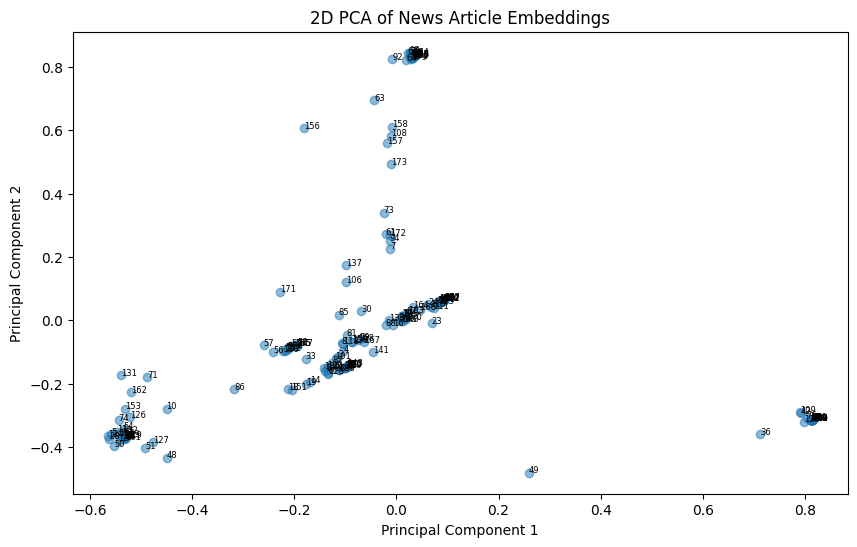

In [29]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming you have a numpy array 'embeddings' with shape (num_articles, 5)
# Replace this with your actual data
# For example, if you have a list of embeddings, you can convert it to a numpy array like this:
# embeddings = np.array(list_of_embeddings)

# Create and fit PCA model
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

# Plot the 2D embeddings
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

# Add labels and title
plt.title('2D PCA of News Article Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add labels to each point
for i, label in enumerate(labels_array):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=6)

# Show the plot
plt.show()

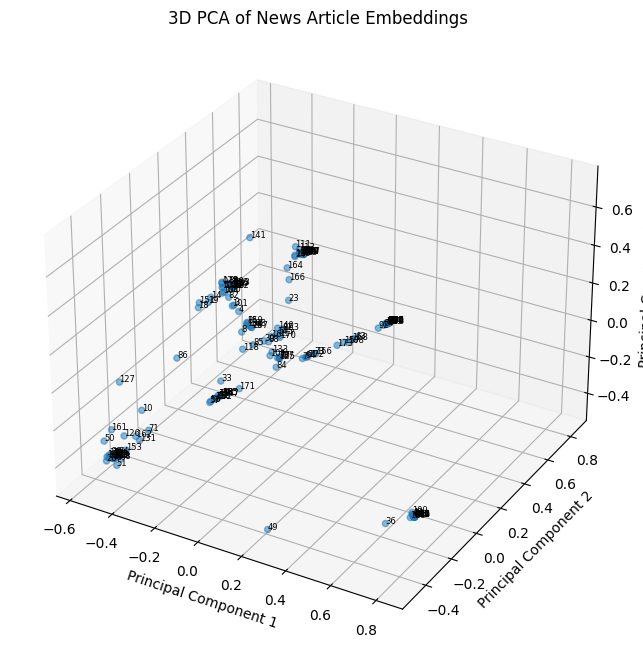

In [30]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import Axes3D for 3D plotting
from sklearn.decomposition import PCA

# Assuming you have a numpy array 'embeddings' with shape (num_articles, 5)
# Replace this with your actual data
# For example, if you have a list of embeddings, you can convert it to a numpy array like this:
# embeddings = np.array(list_of_embeddings)

# Create and fit PCA model with 3 components for 3D
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings_array)

# Plot the 3D embeddings
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], alpha=0.5)

# Add labels and title
ax.set_title('3D PCA of News Article Embeddings')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add labels to each point
for i, label in enumerate(labels_array):
    ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], label, fontsize=6)

# Show the plot
plt.show()


In [31]:
import pandas as pd
import numpy as np

# Assuming df is your dataframe
# Example structure:
# df = pd.DataFrame({'Link': [...], 'Title': [...], 'Summary': [...], 'Article': [...], 'Date': [...],
#                    'Embedding': [embedding_vector_1, embedding_vector_2, ...], 'Wav-link': [...], 'wav_file_name': [...]})

# Assuming embeddings are in numpy arrays
# If not, you may need to convert them to numpy arrays

# Mock function for category prediction (replace this with your actual model prediction)
def get_category_id(embedding):
    # Your code for category prediction based on the embedding
    # For this example, let's assume a random assignment
    categories = ['ARTS AND CULTURE', 'BUSINESS', 'COMEDY', 'CRIME', 'EDUCATION', 'ENTERTAINMENT', 'ENVIRONMENT', 'MEDIA', 'POLITICS', 'RELIGION', 'SCIENCE', 'SPORTS', 'TECH', 'WOMEN']
    return categories[np.argmax(embedding)]

# Create a new column for the embeddings as numpy arrays
df['Embedding'] = df['Embedding'].apply(np.array)

# Add a new column "Category" based on the predicted categories
df['Category'] = df['Embedding'].apply(get_category_id)

# Group by category and count the number of samples in each category
category_counts = df.groupby('Category').size()

# Display the result
print(category_counts)


Category
ARTS AND CULTURE     4
BUSINESS            30
COMEDY               5
CRIME                4
EDUCATION            1
ENTERTAINMENT       21
ENVIRONMENT         10
MEDIA               19
POLITICS            14
RELIGION             4
SCIENCE             24
SPORTS              27
TECH                13
WOMEN                5
dtype: int64


# TTS Example

In [32]:
!pip install gTTS > 0

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
summaries = df['Summary']
summaries

In [ ]:
import pyttsx3

def text_to_speech(text):
    """
    Convert the given text to speech and play it.

    :param text: The text to convert to speech.
    """
    engine = pyttsx3.init()

    # Adjust speech rate (speed)
    rate = engine.getProperty('rate')
    engine.setProperty('rate', rate - 50)

    # Adjust volume
    volume = engine.getProperty('volume')
    engine.setProperty('volume', volume + 0.9)

    engine.say(text)
    engine.runAndWait()

if __name__ == "__main__":
    input_text = "Hello, this is a sample text. Feel free to replace it with your own text."
    text_to_speech(input_text)


In [ ]:
import torch, os
from TTS.api import TTS

# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"

# List available 🐸TTS models
print(TTS().list_models())

# Init TTS
TTS_bark = "tts_models/multilingual/multi-dataset/bark"
TTS_xtts_v2 = "tts_models/multilingual/multi-dataset/xtts_v2"
tts = TTS(TTS_xtts_v2).to(device)

# Run TTS
# ❗ Since this model is multi-lingual voice cloning model, we must set the target speaker_wav and language
# Text to speech list of amplitude values as output
#wav = tts.tts(text="Hello world!", speaker_wav="my/cloning/audio.wav", language="en")
# Text to speech to a file

input_txt="""
Roofs were torn off houses, trees blew down and walls collapsed. Police declared a major incident in Tameside at about 23:45 GMT on Wednesday. Around a hundred homes have been damaged and people are being asked to avoid the area. Storm Gerrit has brought flooding and disrupted travel in Scotland.
"""

alt_input = """
Hello everybody [uh], my name is Marcellino. I am going to introduce you a simple tool of the [he] artificial intelligence [ah].
"""

r_input = """
Ragazzi parliamoci chiaramente, il mio scopo ultimo nella vita è diventare il capo dei boy scout di rignano sull'arno, non mi rompete i coglioni, sto solo cercando di raggiungerlo.
"""

tts.tts_to_file(text=input_txt, speaker_wav=BASE_PATH + "voices/obama.mp3", speed=1.4, language="en", file_path=BASE_PATH + "generated_tts/obama.wav")


# Summarization example

In [ ]:
article_text = """
                Manchester United booked their place in the FA Cup fourth round with a 2-0 victory over Wigan Athletic at Old Trafford on Sunday. Diogo Dalot and Bruno Fernandes scored the goals for the Red Devils, who were dominant throughout the game.
                Manchester United started the game brightly and took the lead after just 13 minutes when Dalot headed home from a corner. The Red Devils doubled their lead just before half-time when Fernandes scored a penalty after he was fouled in the box.
                Wigan were unable to mount a serious challenge in the second half, and Manchester United cruised to victory. The result means that Manchester United are now unbeaten in their last five games in all competitions.
                """

article_text_extract = summarize_article(article_text, num_sentences = 4)
print(article_text_extract)
summary = summarization_pipe(article_text_extract, min_length=20, max_length=100)[0]["summary_text"]
print(summary)